In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 12,6

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
df=pd.read_csv('../Data/Miles_Traveled.csv', index_col=0, parse_dates=True)

In [3]:
df.index.freq='MS'

In [4]:
df.head()

,TRFVOLUSM227NFWA
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


In [5]:
df.index.max()

Timestamp('2018-12-01 00:00:00', freq='MS')

In [6]:
df.describe()

,TRFVOLUSM227NFWA
count,588.000000
mean,190420.380952
std,57795.538934
min,77442.000000
25%,133579.000000
50%,196797.500000
75%,243211.500000
max,288145.000000


In [7]:
df.isnull().all()

TRFVOLUSM227NFWA    False
dtype: bool

In [8]:
df.columns = ['Distance']

# EDA

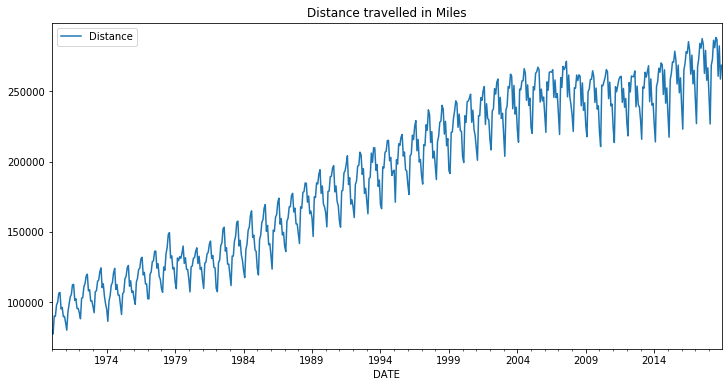

In [9]:
title = 'Distance travelled in Miles'
df.plot(title=title);

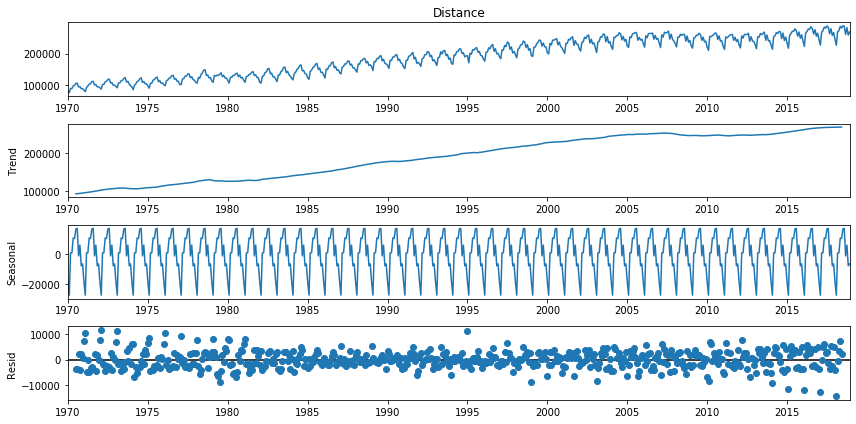

In [10]:
seasonal_decompose(df['Distance'], model='add').plot();

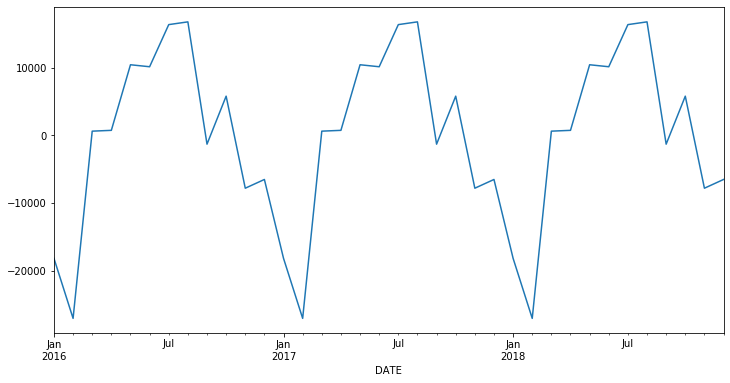

In [11]:
seasonal_decompose(df['Distance'], model='add').seasonal.loc['2016':].plot();

# Train test Split

In [12]:
train = df.iloc[:-12]
test = df.iloc[-12:]

In [13]:
len(train)

576

# Scale Data

In [14]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [15]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

In [16]:
n_input = 12
n_feature = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [17]:
X,y = generator[0]

In [18]:
X.shape, y.shape

((1, 12, 1), (1, 1))

# Model

In [19]:
model=Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_feature)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
model.fit_generator(generator, epochs=50)

Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
564/564 [==============================] - 15s 27ms/step - loss: 0.0133
Epoch 2/50
564/564 [==============================] - 12s 21ms/step - loss: 0.0051
Epoch 3/50
564/564 [==============================] - 12s 21ms/step - loss: 0.0040
Epoch 4/50
564/564 [==============================] - 12s 21ms/step - loss: 0.0029
Epoch 5/50
564/564 [==============================] - 12s 21ms/step - loss: 0.0027
Epoch 6/50
564/564 [==============================] - 12s 21ms/step - loss: 0.0022
Epoch 7/50
564/564 [==============================] - 12s 21ms/step - loss: 0.0017
Epoch 8/50
564/564 [==============================] - 12s 21ms/step - loss: 0.0014
Epoch 9/50
564/564 [==============================] - 12s 22ms/step - loss: 0.0013
Epoch 10/50
564/564 [==============================] - 12s 21ms/step - loss: 0.0011
Epoch 11/50
564/564 [==============================] - 12s 21ms/step - loss

In [25]:
pred_batch = scaled_train[-n_input:].reshape(1,n_input, n_feature)

In [28]:
model.predict(pred_batch)[0], scaled_test[0]

(array([0.7987732], dtype=float32), array([0.80158265]))

In [29]:
test_predictions = []
pred_batch = scaled_train[-n_input:]
current_batch = pred_batch.reshape(1,n_input,n_feature)

for i in range(len(test)):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

In [35]:
test_predictions = scaler.inverse_transform(test_predictions)

In [36]:
test['Predictions'] = test_predictions

In [38]:
test.head()

,Distance,Predictions
DATE,,
2018-01-01,245695.0,245105.299566
2018-02-01,226660.0,228549.432156
2018-03-01,268480.0,266261.851906
2018-04-01,272475.0,273508.754213
2018-05-01,286164.0,285009.784686


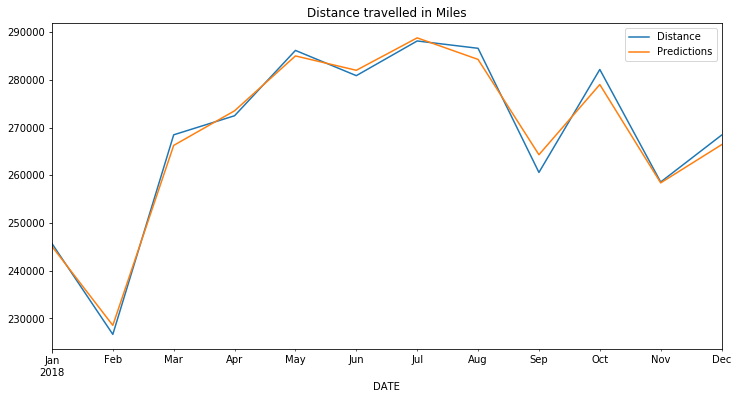

In [37]:
test.plot()
plt.title(title)
plt.legend();

In [39]:
from statsmodels.tools.eval_measures import rmse, mse

In [40]:
print('RMSE: {}'.format(rmse(test['Distance'], test['Predictions'])))
print('MSE: {}'.format(mse(test['Distance'], test['Predictions'])))

RMSE: 1962.0884617533939
MSE: 3849791.131745799


# Predicting Future Data

In [42]:
forecast = []
pred_batch = scaled_train[-n_input:]
current_batch = pred_batch.reshape(1,n_input,n_feature)

for i in range(24):
    pred = model.predict(current_batch)[0]
    forecast.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

In [46]:
forecast = scaler.inverse_transform(forecast)

In [48]:
idx = pd.date_range('2019-1-1',freq='MS', periods=12 )
forecast_pd = pd.DataFrame(forecast[12:], index=idx, columns=['Distance Forecast'])

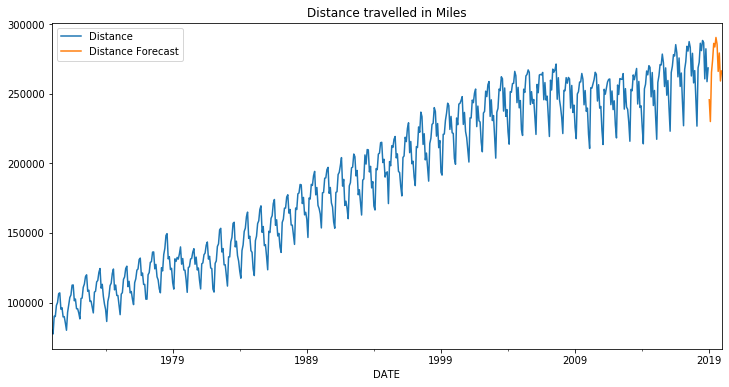

In [50]:
df['Distance'].plot()
forecast_pd['Distance Forecast'].plot()
plt.title(title)
plt.legend();

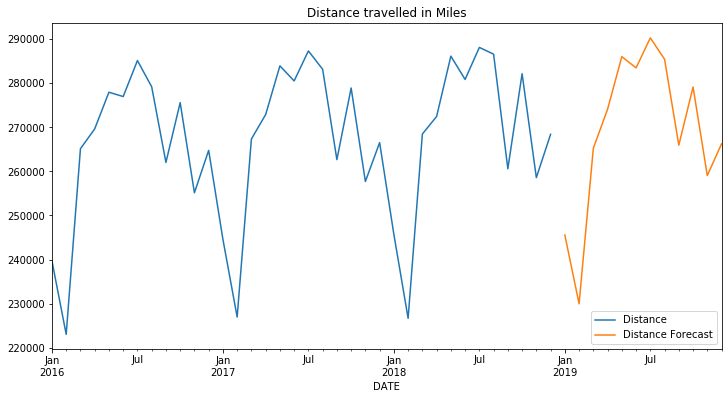

In [51]:
df['Distance'].loc['2016':].plot()
forecast_pd['Distance Forecast'].plot()
plt.title(title)
plt.legend();